# Musical Source Separation and Instrument Recognition

#### Author: Miguel Velez

Deep learning has been successfully applied to audio in recent decades resulting in many products like Apple's Siri and voice isolation technology used by companies like Zoom to improve audio quality. One of the great machine learning problems in this space is Source Separation. A source separation algorithm takes a piece of audio and splits it into separate audio files in which the component pieces of the original are isolated. When applied to music, these techniques allow one to transform a piece of music into separate audio files of isolated instruments.   

In the 2021 documentary series, *The Beatles: Get Back*, director Peter Jackson of *Lord of the Rings* was tasked with remastering footage and audio of The Beatles creating the album *Let It Be*. To create the film, Jackson and his team applied very sophisticated machine learning techniques to isolate each band member's voice and each individual intrument to make their conversations and music clearer. Being able to isolate each sound of interest allowed Jackson to create a timeless documentary restoring a piece of musical history. In the short YouTube video below, director Jackson explains the technologies used to remaster the film. 

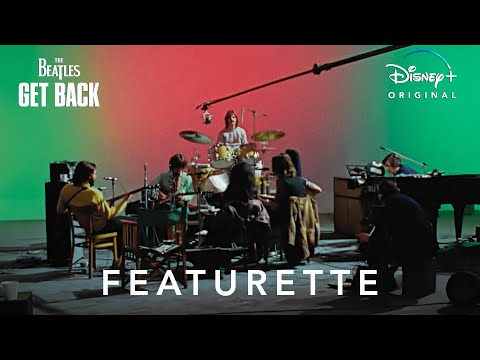

In [21]:
from IPython.display import YouTubeVideo

YouTubeVideo('qQFPnA8OgLo', width=600, height=300)

This is only one example of the tremendous value of source separation technology. As part of my project however, we will make one small step on the road to full source separation with single instrument recognition. Before we can identify the exact components of a sound that belong to an instrument, we will classify audio files by whether or not a single instrument is present or not in the whole clip. To do this, we will use an open source dataset published by Spotify with 20,000 audio samples and 20 instrument labels. The samples can be classified in many different ways ranging from logistic regression to random forest classifier to neural networks, but in this analysis we will Convolutional Neural Networks (CNNs) because they would be the appropriate precursor to a full fledged source separation project. Although we are working with audio and CNNs are most often associated with pattern recognition in images, we will see later on how we can transform audio files into an image representing the sound in a way that is easy to work with using CNNs. 

Therefore, the central question we will explore is, *can we use CNNs to accurately predict whether an instrument is contained in a sample of audio?*


# Spotify OpenMIC-2018 Dataset

The contents of the dataset as described on the host site:

- 10 second snippets of audio, in a directory format like 'audio/{0:3}/{0}.ogg'.format(sample_key)
- VGGish features as JSON objects, in a directory format like 'vggish/{0:3}/{0}.json'.format(sample_key)
- MD5 checksums for each OGG and JSON file
- Anonymized individual responses, in 'openmic-2018-individual-responses.csv'
- Aggregated labels, in 'openmic-2018-aggregated-labels.csv'
- Track metadata, with licenses for each audio recording, in 'openmic-2018-metadata.csv'
- A Python-friendly NPZ file of features and labels, 'openmic-2018.npz'
- Sample partitions for train and test, in 'partitions/*.txt'

`SOURCE`: https://zenodo.org/record/1432913#.Yn0haPXMKHG

`CITATION`: Humphrey, Eric J., Durand, Simon, and McFee, Brian. "OpenMIC-2018: An Open Dataset for Multiple Instrument Recognition." in Proceedings of the 19th International Society for Music Information Retrieval Conference (ISMIR), 2018.

We will take a more detailed look at the contents of this dataset but for our purposes, the ten second snippets of audio, the sample partitions of test and train, the class-map of instruments labels, and the "Python-friendly" npz file containing the target variable are what we will need to complete the objective.

The [VGGish features](https://github.com/tensorflow/models/tree/master/research/audioset) of the second bullet above are features provided by Spotify using a pretrained neural network by Google named VGGish to transform the audio into numerical features amenable to other classification methods like logistic regression. For now, we will not be using these features so that we can journey through building our own CNN.

The two csv's "individual-responses" and "aggregated-labels" can be used to create the target classification labels but for now, we will use a target created by Spotify and stored in the npz file above. The csv file "metadata" contains more detailed information about the ten second snippets like the artist, album, date, and genres of the song.

# Data Preprocessing

Before running anything, please ensure that this notebook is in the same directory as the Spotify OpenMIC-2018 dataset.

To begin we will take a look at transforming audio files into images. We will be using the librosa package which can be downloaded using `conda install`. We will pick one of the 20,000 audio samples at random to show how the conversion is done but the image creation will be detailed in a python script named "create_images.py". Then we will unpack the target variable to show how its organized. 

In [22]:
import os # For navigating directories
import json # Used to load json files
import librosa # Package with many wonderful audio signal processing functions
import numpy as np  # Mathematical functions
import pandas as pd # Used for dataframes
import seaborn as sns  # To create confusion matrix
import librosa.display # Required for librosa to display figure
import matplotlib.pyplot as plt # Plotting... Serves as the backbone of librosa.display
from IPython.display import Audio # To playback audio from within notebook

## Loading and visualizing sound

In [28]:
# We will be using sample key 006782_88320 to display

wave, sr = librosa.load('openmic-2018/audio/006/006782_88320.ogg')

As most people vaguely know, sounds are pressure waves interpreted by our ear drums. When we load the audio sample using librosa, the wave variable stores the data corresponding the undulations of that wave. The other variable "sr" corresponds to the sampling rate of that wave. Below you can listen to the playback of the audio.

In [29]:
# Audio playback
Audio(data=wave, rate=sr)

As you can hopefully hear from the clip, it is mostly an acoustic sound and the "loudness" of the sound spikes every time the stringed instrument is plucked. We can see this is the case by visualizing the image as pressure waves:

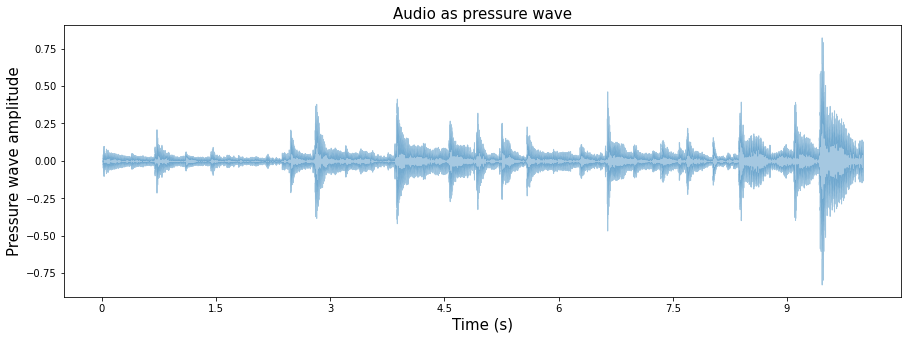

In [33]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(wave, sr=sr, alpha=0.4)
plt.xlabel("Time (s)",fontsize=15)
plt.ylabel("Pressure wave amplitude",fontsize=15)
plt.title('Audio as pressure wave',fontsize=15)
plt.show()

However, this is not a convenient representation of our audio for a CNN to find patterns within. You can see that most of the image is white space and the information distinguishing one sound from another is hidden in all the different frequencies that add up to one sound. To remedy this we will transform the pressure wave using a famous mathematical procedure known as the Fourier Transform that decomposes a function defined in a spatial domain into functions defined by spatial frequency. In terms of sound, we can decompose the pressure wave into the different frequencies that compose it. More specifically we will be using the Short-Time Fourier Transform, that applies the Fourier Transform to the image in small time steps to see how the frequencies making up the sound change over time. This may be somewhat confusing but luckily understanding the bulk of the project does not depend on understanding the Fourier Transform deeply as that is something you would find learning theory in applied mathematics. Below we can see the product of such a transformation:

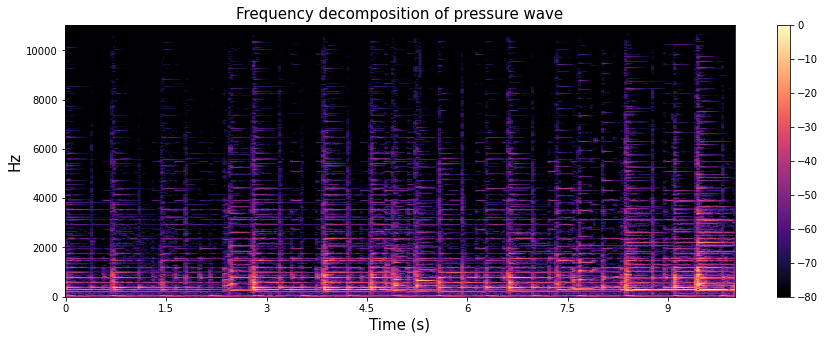

In [37]:
plt.figure(figsize=(15, 5))
S = np.abs(librosa.stft(wave))
D = librosa.amplitude_to_db(S, ref=np.max)
librosa.display.specshow(D, y_axis='hz', x_axis='s',sr=sr)
plt.title('Frequency decomposition of pressure wave',fontsize=15)
plt.ylabel('Hz',fontsize=15)
plt.xlabel('Time (s)',fontsize=15)
plt.colorbar()
plt.show()

These types of images are called spectrograms so I will refer to them as such going forward. In the spectrogram shown above, the lighter spots indicate the frequency that carries most of the energy in the signal at that time. The units on the y-axis are Hertz, the units of frequency. We can see that most of the action happens at lower frequencies, therefore I hypothesize that a log rescaling of the y-axis will help the CNN identify important patterns.

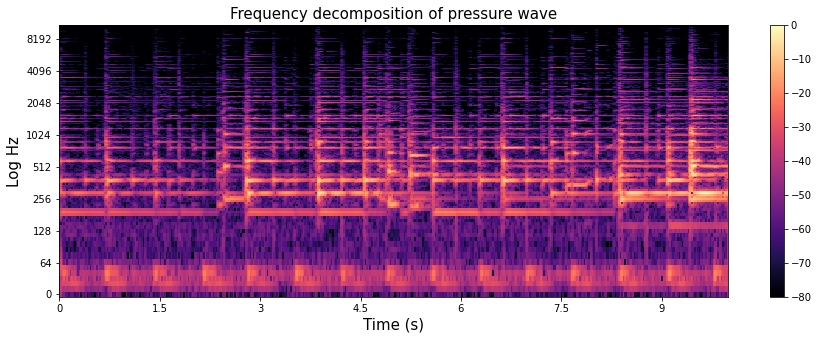

In [40]:
plt.figure(figsize=(15, 5))
S = np.abs(librosa.stft(wave))
D = librosa.amplitude_to_db(S, ref=np.max)
librosa.display.specshow(D, y_axis='log', x_axis='s',sr=sr)
plt.title('Frequency decomposition of pressure wave',fontsize=15)
plt.ylabel('Log Hz',fontsize=15)
plt.xlabel('Time (s)',fontsize=15)
plt.colorbar()
plt.show()

This image seems much more informative about what is going on in the audio file than the previous one. Now we will compare the images produced by this stringed instrument with one of wind instrument to get a sense of how differences between them are much clearer when views as a spectrogram. 

In [53]:
wave_wind, sr = librosa.load('openmic-2018/audio/145/145993_134400.ogg')

# Audio playback
Audio(data=wave_wind, rate=sr)

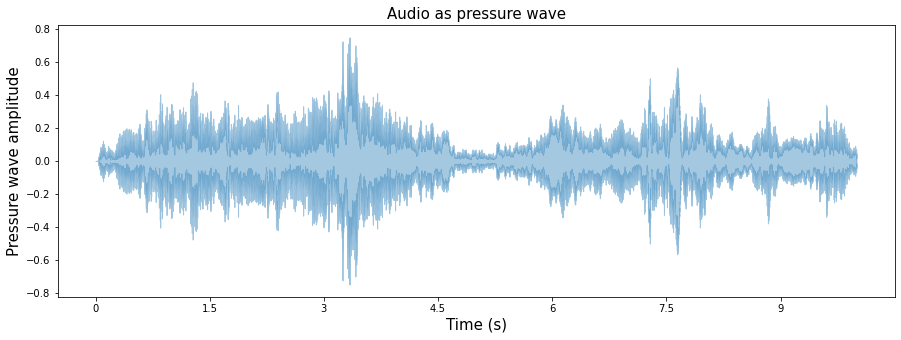

In [54]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(wave_wind, sr=sr, alpha=0.4)
plt.xlabel("Time (s)",fontsize=15)
plt.ylabel("Pressure wave amplitude",fontsize=15)
plt.title('Audio as pressure wave',fontsize=15)
plt.show()

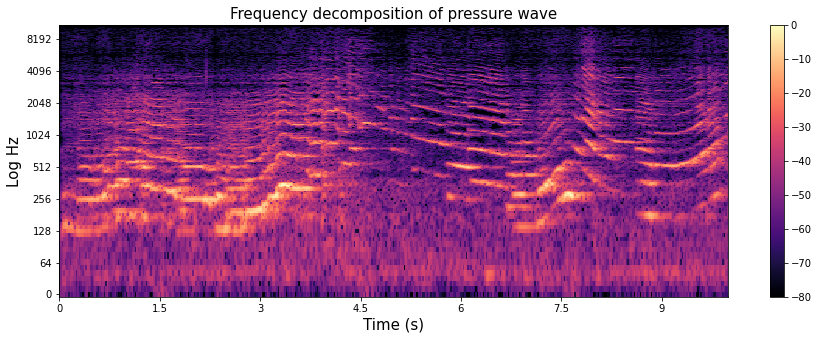

In [55]:
plt.figure(figsize=(15, 5))
S = np.abs(librosa.stft(wave_wind))
D = librosa.amplitude_to_db(S, ref=np.max)
librosa.display.specshow(D, y_axis='log', x_axis='s',sr=sr)
plt.title('Frequency decomposition of pressure wave',fontsize=15)
plt.ylabel('Log Hz',fontsize=15)
plt.xlabel('Time (s)',fontsize=15)
plt.colorbar()
plt.show()

We can see that the audible difference between the vibe of both instruments is that the wind instrument flows more between frequencies while the stringed instrument is much sharper because they are plucked. This difference can be seen in both the waveform pressure wave and the spectrogram but it is much more informatively visualized in the spectrogram. 

In terms of modeling, in "create_images.py", we loop through all the directories where audio is stored, transform it into an image of this kind, remove all axis labels and colorbar, then save the image to a new directory named "Image_Data". More details about the workings of the that file can be found in the README associated with this project or in the python script itself. Now we will discuss how to retreive the target variable from the materials that Spotify provided. 

## Target variable

In [23]:
# Loading binary target variable y, array of sample keys, and class-map of indices and instrument names

npz_file = 'openmic-2018/openmic-2018.npz'
OPENMIC = np.load(npz_file,allow_pickle=True)    
y_mask, sample_key = OPENMIC['Y_mask'], OPENMIC['sample_key']

class_map_file = 'openmic-2018/class-map.json'
class_map = json.load(open(class_map_file, 'r'))

In [24]:
# Turning target array into Dataframe
y_df = pd.DataFrame(y_mask, index=sample_key, columns=class_map.keys()).astype('int32')
y_df.head()

,accordion,banjo,bass,cello,clarinet,cymbals,drums,flute,guitar,mallet_percussion,mandolin,organ,piano,saxophone,synthesizer,trombone,trumpet,ukulele,violin,voice
000046_3840,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
000135_483840,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
000139_119040,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
000141_153600,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
000144_30720,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Class imbalance

One of the challenges of this dataset is that there is a wide class imbalance between containing or not containing an instrument. This more time, I would experiment with resampling (upsampling audio clips containing the instrument of choice and downsampling the audio clips without the instrument), but for now we will continue as is.

In [25]:
# Baseline accuracy
for column in y_df.columns:
    print(f'{column}:\n{y_df[column].value_counts(normalize=True)}\n')    

accordion:
0    0.89645
1    0.10355
Name: accordion, dtype: float64

banjo:
0    0.8891
1    0.1109
Name: banjo, dtype: float64

bass:
0    0.9056
1    0.0944
Name: bass, dtype: float64

cello:
0    0.90255
1    0.09745
Name: cello, dtype: float64

clarinet:
0    0.88075
1    0.11925
Name: clarinet, dtype: float64

cymbals:
0    0.91325
1    0.08675
Name: cymbals, dtype: float64

drums:
0    0.91265
1    0.08735
Name: drums, dtype: float64

flute:
0    0.8958
1    0.1042
Name: flute, dtype: float64

guitar:
0    0.9175
1    0.0825
Name: guitar, dtype: float64

mallet_percussion:
0    0.9099
1    0.0901
Name: mallet_percussion, dtype: float64

mandolin:
0    0.8768
1    0.1232
Name: mandolin, dtype: float64

organ:
0    0.9055
1    0.0945
Name: organ, dtype: float64

piano:
0    0.914
1    0.086
Name: piano, dtype: float64

saxophone:
0    0.88175
1    0.11825
Name: saxophone, dtype: float64

synthesizer:
0    0.9199
1    0.0801
Name: synthesizer, dtype: float64

trombone:
0    0.862
1

We can see that the trumpet has the least class imbalance at around 15% of the records indicating there is a trumpet in the sample. Because trumpets are the most represented instrument, the analysis in this notebook will carrying using it as the single instrument being classified. However, this imbalance needs to be kept in mind when considering the accuracy of the model.

# Modeling

Our strategy with respect to modeling will be using CNNs as stated previously. Here we will give it two different attempts: a simple CNN architecture of our creation and using the pretrained CNN ResNet-50 as the base of a smaller network. 

## TensorFlow Image Generator

Image Generator methods in TensorFlow allow us to load each image individually as needed directly from the directory where the images are stored. We will use this for both of our modeling strategies. When specifying the directory to our images, this notebook was written under the assumption that this notebook is in the same directory as the folder "Image_Data" where the images are stored.

In [93]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the dimensions we want our images to be preprocessed to
# (This will allow us to images of different resolutions)
height = 224 
width = 224
channels = 3

# Create training image data generator.
train_datagen = ImageDataGenerator(rescale=1./255)

# Create validation image data generator.
# Only apply rescaling to our validation data.
validation_datagen = ImageDataGenerator(rescale=1./255)

# Finaly we specify where the images should be loaded from
# as well as some additional attributes:
train_generator=train_datagen.flow_from_directory('Image_Data/Train',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical')

validation_generator=validation_datagen.flow_from_directory('Image_Data/Validation',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical')

Found 10441 images belonging to 2 classes.
Found 4474 images belonging to 2 classes.


## Modeling Strategy 1: Simple CNN

In [58]:
# Specific neural network models & layer types
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

### Building the model

In [94]:
simpleCNN = Sequential()

# Convolutional layers
# Pool for dimensionality reduction
# Dropout to reduce overfitting
simpleCNN.add(Conv2D(32, kernel_size=(3, 3), 
                     activation = 'relu', 
                     input_shape = (height, width, channels)))
simpleCNN.add(MaxPooling2D(pool_size=(2, 2)))
simpleCNN.add(Dropout(0.33))

simpleCNN.add(Conv2D(64, (3, 3), activation='relu'))
simpleCNN.add(MaxPooling2D(pool_size=(2, 2)))
simpleCNN.add(Dropout(0.33))

simpleCNN.add(Conv2D(32, (3, 3), activation='relu'))
simpleCNN.add(MaxPooling2D(pool_size=(2, 2)))
simpleCNN.add(Dropout(0.33))

simpleCNN.add(Conv2D(64, (3, 3), activation='relu'))
simpleCNN.add(MaxPooling2D(pool_size=(2, 2)))
simpleCNN.add(Dropout(0.33))

# Flatten the output of convolutional layers
simpleCNN.add(Flatten())

# Dense layers
simpleCNN.add(Dense(256, activation='relu'))
simpleCNN.add(Dropout(0.25))
simpleCNN.add(Dense(512, activation='relu'))
simpleCNN.add(Dropout(0.25))

simpleCNN.add(Dense(128, activation='relu'))
simpleCNN.add(Dense(64, activation='relu'))
simpleCNN.add(Dense(32, activation='relu'))
simpleCNN.add(Dense(2, activation='softmax'))

simpleCNN.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 111, 111, 32)      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 54, 54, 64)       

### Training the model

Keep in mind as we evaluate our model's accuracy, that the baseline accuracy for trumpet if the model guesses "no" for every sample is an accuracy of 85.42%.

Currently the validation accuracy regardless of architecture has been val_accuracy = 0.8530

In [95]:
simpleCNN.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', 
                           patience=5, 
                           mode='max', 
                           verbose=1)

simpleCNN.fit(train_generator,
          epochs=10,
          validation_data = validation_generator,
          callbacks=[early_stop])

Epoch 1/10
327/327 [==============================] - 274s 836ms/step - loss: 0.4241 - accuracy: 0.8541 - val_loss: 0.4365 - val_accuracy: 0.8587
Epoch 2/10
327/327 [==============================] - 259s 790ms/step - loss: 0.4124 - accuracy: 0.8564 - val_loss: 0.4095 - val_accuracy: 0.8587
Epoch 3/10
327/327 [==============================] - 270s 825ms/step - loss: 0.4047 - accuracy: 0.8564 - val_loss: 0.3991 - val_accuracy: 0.8587
Epoch 4/10
327/327 [==============================] - 233s 712ms/step - loss: 0.4057 - accuracy: 0.8564 - val_loss: 0.3920 - val_accuracy: 0.8587
Epoch 5/10
327/327 [==============================] - 233s 714ms/step - loss: 0.3950 - accuracy: 0.8564 - val_loss: 0.3911 - val_accuracy: 0.8587
Epoch 6/10
327/327 [==============================] - 270s 825ms/step - loss: 0.3920 - accuracy: 0.8564 - val_loss: 0.3853 - val_accuracy: 0.8587
Epoch 6: early stopping


### Model evaluation

In [96]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('Image_Data/Test',
                                                  target_size=(height,width),
                                                  color_mode='rgb',
                                                  batch_size=5085,
                                                  class_mode='categorical')

X_test, y_test = test_generator.next()

Found 5085 images belonging to 2 classes.


#### Test Accuracy

In [97]:
# Evaluate the model's performance on the test data
score = simpleCNN.evaluate(X_test, y_test, verbose=1)

print('Test accuracy:', score[1])

159/159 [==============================] - 30s 187ms/step - loss: 0.4122 - accuracy: 0.8456
Test accuracy: 0.8456243872642517


159/159 [==============================] - 36s 225ms/step


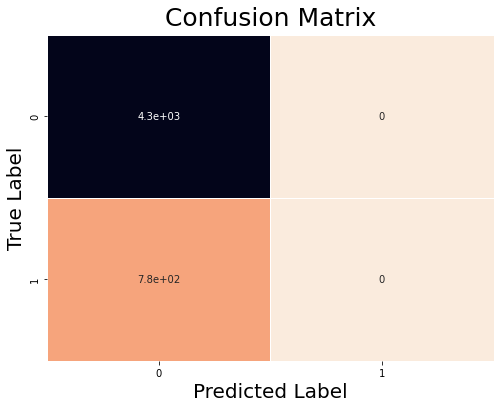

In [98]:
# Calculate the predictions
predict_probas = simpleCNN.predict(X_test)

# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1);

from sklearn.metrics import confusion_matrix

# Convert our test labels from one-hot encoding to label encoding
y_test_labels = np.argmax(y_test, axis=1)

conf_mat = confusion_matrix(y_test_labels, y_predict)

plt.figure(figsize = (8,6))
sns.heatmap(conf_mat,
            annot=True,
            cbar=False,
            cmap="rocket_r",
            linewidths=1,
            
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

Herein lies the major issue I have had building my own CNN architecture. I explored many architectures and invite the reader to do so also but, each time, my network predicts "no" to every sample it receives. Therefore the accuracy of train, validation, and test is simply the proportion of samples without trumpet in each set. Now we will use the pretrained network ResNet-50 as a base, on top of which we will add some trainable layers. 

## Modeling Strategy 2: ResNet-50

ResNet-50 is a deep CNN with 50 convolutional layers using "Residual learning". What residual learning is is beyond the scope of this project but TensorFlow makes these models easily available. The model was pretrained using the [ImageNet](https://image-net.org/). The ImageNet dataset is composed of images from the internet designed to help advance computer vision research in object recognition. The one hesitation is that ImageNet was likely trained using normal objects humans take pictures of like dogs, cars, mountains and trees. The "objects" in my images are quite different than that but we will move forward regardless and see if it can help. We will use the same image generators defined above but will continue on to model building.

### Buidling the model

In [78]:
from tensorflow.keras.applications import ResNet50V2

model = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(height,width,channels))
model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
          

 vation)                                                                                          
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
          

 conv4_block3_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
          

                                                                 ]                                
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
          

                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 7, 7, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalizat

We can see above that there are 23.5 million parameters in the ResNet50 model with its "imagenet" weights. Below we will freeze these parameters since they have already been trained to have certain weights and it would be computationally expensive to continue training all those weights. Instead we add a few layers to the top of ResNet50 that are trainable on our images. 

In [86]:
# Freeze all the layers in the base model
for layer in model.layers:
    layer.trainable = False
    
    
from tensorflow.keras.models import Model

x = model.output

x = Flatten()(x)
x = Dense(256,activation = 'relu')(x)
x = Dropout(.25)(x)

x = Dense(256,activation = 'relu')(x)
x = Dropout(.25)(x)

x = Dense(128,activation = 'relu')(x)
x = Dense(64,activation = 'relu')(x)
x = Dense(32,activation = 'relu')(x)
output = Dense(2,activation = 'softmax')(x)

model = Model(inputs=model.input, 
              outputs=output)

#model.summary()

### Training the model

In [87]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', 
                           patience=5, 
                           mode='max', 
                           verbose=1)

model.fit(train_generator,
          epochs=10,
          validation_data = validation_generator,
          callbacks=[early_stop])

Epoch 1/10
138/138 [==============================] - 191s 1s/step - loss: 0.4222 - accuracy: 0.8584 - val_loss: 0.4174 - val_accuracy: 0.8530
Epoch 2/10
138/138 [==============================] - 193s 1s/step - loss: 0.4118 - accuracy: 0.8595 - val_loss: 0.4190 - val_accuracy: 0.8530
Epoch 3/10
138/138 [==============================] - 196s 1s/step - loss: 0.4098 - accuracy: 0.8595 - val_loss: 0.4184 - val_accuracy: 0.8530
Epoch 4/10
138/138 [==============================] - 196s 1s/step - loss: 0.4072 - accuracy: 0.8595 - val_loss: 0.4175 - val_accuracy: 0.8530
Epoch 5/10
138/138 [==============================] - 198s 1s/step - loss: 0.4104 - accuracy: 0.8595 - val_loss: 0.4181 - val_accuracy: 0.8530
Epoch 6/10
138/138 [==============================] - 203s 1s/step - loss: 0.4093 - accuracy: 0.8595 - val_loss: 0.4191 - val_accuracy: 0.8530
Epoch 6: early stopping


### Model evaluation

In [82]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('Image_Data/Test',
                                                  target_size=(height,width),
                                                  color_mode='rgb',
                                                  batch_size=5085,
                                                  class_mode='categorical')

X_test, y_test = test_generator.next()

Found 5085 images belonging to 2 classes.


In [83]:
# Evaluate the model's performance on the test data
score = model.evaluate(X_test, y_test, verbose=1)

print('Test accuracy:', score[1])

159/159 [==============================] - 151s 953ms/step - loss: 0.4308 - accuracy: 0.8456
Test accuracy: 0.8456243872642517


159/159 [==============================] - 154s 965ms/step


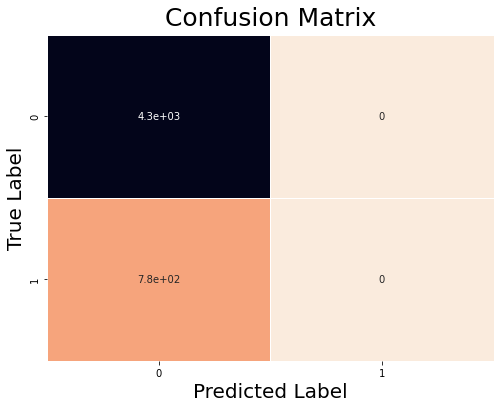

In [84]:
# Calculate the predictions
predict_probas = model.predict(X_test)

# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)

# Convert our test labels from one-hot encoding to label encoding
y_test_labels = np.argmax(y_test, axis=1)

conf_mat = confusion_matrix(y_test_labels, y_predict)

plt.figure(figsize = (8,6))
sns.heatmap(conf_mat,
            annot=True,
            cbar=False,
            cmap="rocket_r",
            linewidths=1,
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

We've been here before, the model is predicting no trumpets! At this stage I would breakdown my accuracy in terms of precision and recall except if we have no predictions where the instrument is present then those metrics don't make sense. Before I figured out how to get all of the data into memory at once, I was only able to load about 40% of the dataset. We will use this folder named "Image_Data40%" to see if having less images to train on improves our accuracy. I will attempt to include this folder with my submission if space allows for it.

### ResNet-50 with 40% of the data

In [89]:
# Specify the dimensions we want our images to be preprocessed to
# (This will allow us to images of different resolutions)
height = 224 
width = 224
channels = 3

# Create training image data generator.
train_datagen = ImageDataGenerator(rescale=1./255)

# Create validation image data generator.
# Only apply rescaling to our validation data.
validation_datagen = ImageDataGenerator(rescale=1./255)

# Finaly we specify where the images should be loaded from
# as well as some additional attributes:
train_generator=train_datagen.flow_from_directory('Image_Data40%/Train',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical')

validation_generator=validation_datagen.flow_from_directory('Image_Data40%/Validation',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical')


model = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(height,width,channels))


# Freeze all the layers in the base model
for layer in model.layers:
    layer.trainable = False
    
    
from tensorflow.keras.models import Model

x = model.output

x = Flatten()(x)
x = Dense(256,activation = 'relu')(x)
x = Dropout(.25)(x)

x = Dense(256,activation = 'relu')(x)
x = Dropout(.25)(x)

x = Dense(128,activation = 'relu')(x)
x = Dense(64,activation = 'relu')(x)
x = Dense(32,activation = 'relu')(x)
output = Dense(2,activation = 'softmax')(x)

model = Model(inputs=model.input, 
              outputs=output)

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', 
                           patience=5, 
                           mode='max', 
                           verbose=1)

model.fit(train_generator,
          epochs=10,
          validation_data = validation_generator,
          callbacks=[early_stop])

Found 4385 images belonging to 2 classes.
Found 1912 images belonging to 2 classes.
Epoch 1/10
138/138 [==============================] - 204s 1s/step - loss: 0.6180 - accuracy: 0.8274 - val_loss: 0.4353 - val_accuracy: 0.8530
Epoch 2/10
138/138 [==============================] - 200s 1s/step - loss: 0.4056 - accuracy: 0.8595 - val_loss: 0.4034 - val_accuracy: 0.8530
Epoch 3/10
138/138 [==============================] - 195s 1s/step - loss: 0.3824 - accuracy: 0.8602 - val_loss: 0.4018 - val_accuracy: 0.8530
Epoch 4/10
138/138 [==============================] - 194s 1s/step - loss: 0.3265 - accuracy: 0.8780 - val_loss: 0.4320 - val_accuracy: 0.8515
Epoch 5/10
138/138 [==============================] - 193s 1s/step - loss: 0.2654 - accuracy: 0.8971 - val_loss: 0.4557 - val_accuracy: 0.8483
Epoch 6/10
138/138 [==============================] - 193s 1s/step - loss: 0.1985 - accuracy: 0.9195 - val_loss: 0.5365 - val_accuracy: 0.8525
Epoch 6: early stopping


Found 2189 images belonging to 2 classes.
69/69 [==============================] - 63s 908ms/step - loss: 0.5698 - accuracy: 0.8397
Test accuracy: 0.8396528363227844
69/69 [==============================] - 62s 900ms/step


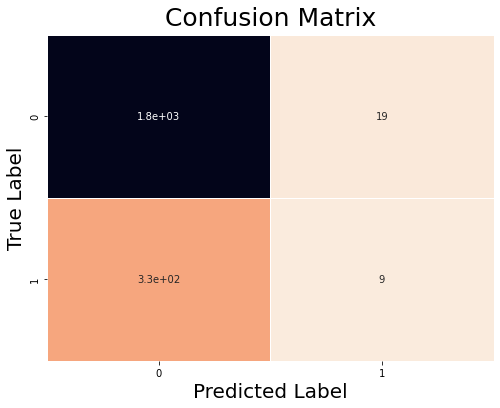

In [91]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('Image_Data40%/Test',
                                                  target_size=(height,width),
                                                  color_mode='rgb',
                                                  batch_size=2189,
                                                  class_mode='categorical')

X_test, y_test = test_generator.next()

# Evaluate the model's performance on the test data
score = model.evaluate(X_test, y_test, verbose=1)

print('Test accuracy:', score[1])

# Calculate the predictions
predict_probas = model.predict(X_test)

# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)

# Convert our test labels from one-hot encoding to label encoding
y_test_labels = np.argmax(y_test, axis=1)

conf_mat = confusion_matrix(y_test_labels, y_predict)

plt.figure(figsize = (8,6))
sns.heatmap(conf_mat,
            annot=True,
            cbar=False,
            cmap="rocket_r",
            linewidths=1,
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

Finally, we have a model that does not just predict no each time. We are still not doing so hot since our "yes" predictions are wrong about 2/3 of the time. Since our model is now attempting to predict some samples as having a trumpet, we can calculate our classification report.

In [92]:
from sklearn.metrics import classification_report
print(classification_report(y_test_labels, y_predict))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      1848
           1       0.32      0.03      0.05       341

    accuracy                           0.84      2189
   macro avg       0.58      0.51      0.48      2189
weighted avg       0.76      0.84      0.78      2189



Our precision and recall are quite bad but we still have an improvement over our previous models. It is as yet unclear to me why using an incomplete dataset helped the model learn features of what makes an image a trumpet rather than only learning to predict no trumpet.

My last stand against this problem is to manually downsample the number of "no trumpet" samples in my train folder within "Image_Data". I will duplicated my folder "Image_Data", name it "Image_Data_resampled", and delete enough of the images in train folder that do not contain trumpets to make the ratio of no trumpet images 2:1 with trumpet images.

### ResNet-50 with resampled train set

Using this new resampled dataset there are 3000 train images that do not contain trumpets and 1500 train images that do contain trumpets. Therefore the new baseline accuracy score for the train set if the model predicts no each time is about 66.6%. 

In [99]:
# Specify the dimensions we want our images to be preprocessed to
# (This will allow us to images of different resolutions)
height = 224 
width = 224
channels = 3

# Create training image data generator.
train_datagen = ImageDataGenerator(rescale=1./255)

# Create validation image data generator.
# Only apply rescaling to our validation data.
validation_datagen = ImageDataGenerator(rescale=1./255)

# Finaly we specify where the images should be loaded from
# as well as some additional attributes:
train_generator=train_datagen.flow_from_directory('Image_Data_resampled/Train',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical')

validation_generator=validation_datagen.flow_from_directory('Image_Data_resampled/Validation',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical')


model = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(height,width,channels))


# Freeze all the layers in the base model
for layer in model.layers:
    layer.trainable = False
    
    
from tensorflow.keras.models import Model

x = model.output

x = Flatten()(x)
x = Dense(256,activation = 'relu')(x)
x = Dropout(.25)(x)

x = Dense(256,activation = 'relu')(x)
x = Dropout(.25)(x)

x = Dense(128,activation = 'relu')(x)
x = Dense(64,activation = 'relu')(x)
x = Dense(32,activation = 'relu')(x)
output = Dense(2,activation = 'softmax')(x)

model = Model(inputs=model.input, 
              outputs=output)

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', 
                           patience=5, 
                           mode='max', 
                           verbose=1)

model.fit(train_generator,
          epochs=10,
          validation_data = validation_generator,
          callbacks=[early_stop])

Found 4495 images belonging to 2 classes.
Found 4474 images belonging to 2 classes.
Epoch 1/10
141/141 [==============================] - 302s 2s/step - loss: 0.7544 - accuracy: 0.6216 - val_loss: 0.4932 - val_accuracy: 0.8565
Epoch 2/10
141/141 [==============================] - 290s 2s/step - loss: 0.6229 - accuracy: 0.6805 - val_loss: 0.5519 - val_accuracy: 0.7747
Epoch 3/10
141/141 [==============================] - 284s 2s/step - loss: 0.5728 - accuracy: 0.7137 - val_loss: 0.4251 - val_accuracy: 0.8456
Epoch 4/10
141/141 [==============================] - 283s 2s/step - loss: 0.4982 - accuracy: 0.7586 - val_loss: 0.3870 - val_accuracy: 0.8583
Epoch 5/10
141/141 [==============================] - 281s 2s/step - loss: 0.4231 - accuracy: 0.8069 - val_loss: 0.6094 - val_accuracy: 0.6916
Epoch 6/10
141/141 [==============================] - 282s 2s/step - loss: 0.3336 - accuracy: 0.8501 - val_loss: 0.6178 - val_accuracy: 0.7852
Epoch 7/10
141/141 [==============================] - 286s

Found 5085 images belonging to 2 classes.
69/69 [==============================] - 66s 949ms/step - loss: 0.7109 - accuracy: 0.7771
Test accuracy: 0.7770671248435974
69/69 [==============================] - 66s 945ms/step


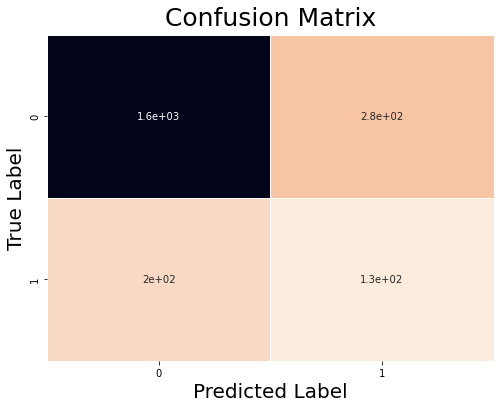

In [100]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('Image_Data_resampled/Test',
                                                  target_size=(height,width),
                                                  color_mode='rgb',
                                                  batch_size=2189,
                                                  class_mode='categorical')

X_test, y_test = test_generator.next()

# Evaluate the model's performance on the test data
score = model.evaluate(X_test, y_test, verbose=1)

print('Test accuracy:', score[1])

# Calculate the predictions
predict_probas = model.predict(X_test)

# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)

# Convert our test labels from one-hot encoding to label encoding
y_test_labels = np.argmax(y_test, axis=1)

conf_mat = confusion_matrix(y_test_labels, y_predict)

plt.figure(figsize = (8,6))
sns.heatmap(conf_mat,
            annot=True,
            cbar=False,
            cmap="rocket_r",
            linewidths=1,
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

In [101]:
from sklearn.metrics import classification_report
print(classification_report(y_test_labels, y_predict))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1851
           1       0.32      0.40      0.35       338

    accuracy                           0.78      2189
   macro avg       0.60      0.62      0.61      2189
weighted avg       0.80      0.78      0.79      2189



Excitingly, we can see above that, although overall test accuracy decreased, the number of "yes" predictions increased greatly and so did our recall score. At this stage in the model evaluation I would usually pull up images classified incorrectly to probe the model and see what kinds of errors it is making. However, in this case, the images are very hard to inspect visually for humans. It is not so instructive to compare images our model predicted wrong with images of the correct response. 

# Conclusion & Future Work

In this notebook, we used Spotify's OpenMIC-2018 dataset to go through the creation of spectrogram images and how to apply computer vision techniques to these images to classify whether a trumpet is present in the audio file corresponding to the spectrogram image. In our first attempt with a CNN architecture we created ourselves, we saw that the model was not learning at all from the data. The accuracy score on the train set remained at the constant value one would get for guessing "no trumpet" for every sample. In our second attempt we use a pre-trained CNN called ResNet-50. In this case, we still had trouble getting the model to predict "yes" for any sample and the train accuracy never improved through the epochs: the model is not learning anything. Lastly, we tried the ResNet-50 model using only 40% of the data and tried using ResNet-50 with a resampled dataset. Using 40% of the data, the model was able to learn how to predict the train set quite well but the accuracy for our test set did not improve. However, our model was attempting to predict samples containing trumpets which is an improvement. Finally, we fit the model using resampled data and found that it negatively affected test set accuracy but greatly increases the number of "yes" predictions that the model makes. 

Although these preliminary results are dissapointing, I am confident that with more work these models can improved greatly. For starters, the data used to train ResNet is completely different than the kinds of data being fed into the model in this project. There is a different pretrained model architecture named [VGGish](https://pypi.org/project/vggish-keras/) that is compatible with TensorFlow. However, this model is less developed and therefore not contained in the [tensorflow.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module from which I imported ResNet-50. Using a model pretrained on spectrogram images would certainly help me take this model to the next step. 